# https://www.univ-montp3.fr/miap/ens/miashs/master/ues/test_maximilien/htmls/6_deeplearning/2_filters_representation.html#v-visualisation-des-filtres-parametres-appris

In [38]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import datasets, models
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import umap
import plotly.express as px

import numpy as np

import copy

# Paramétrage

In [5]:
import os
# Each itereates over the dataloader define with batch size will get a batch of batch size samples
# After the iterator has gone through every data sample (one epoch), then we shuffle the order and we go again.
batch_size = 128
num_workers = 2

# I. Construction du jeu de données CIFAR10

## Méthode de split

In [7]:
def split_dataset(dataset, valid_size = 0.0, random_state=42):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(valid_size * dataset_size))

    np.random.seed(random_state)
    np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    return dataset, copy.deepcopy(dataset), train_sampler, valid_sampler

## Construction du jeu de données

In [45]:
# label names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

transform = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ]
)

#root_directory where images are.
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

trainset, validset, train_sampler, valid_sampler = split_dataset(trainset, valid_size = 0.2, random_state=None)

trainloader = DataLoader(
  trainset, batch_size=batch_size, sampler=train_sampler,
  num_workers=num_workers,
)

validloader = DataLoader(
  validset, batch_size=batch_size, sampler=valid_sampler,
  num_workers=num_workers,
)

print(len(trainloader), len(validloader))

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(
  testset, batch_size=batch_size, shuffle=True,
  num_workers=num_workers,
)

print('Nb test batchs:', len(testloader))

Files already downloaded and verified
10000 2500
Files already downloaded and verified
Nb test batchs: 2500


# Visualisation des données

## Méthode de visualisation

In [51]:
#### Visualisation d'images du jeu de données
import matplotlib.pyplot as plt
import numpy as np

def imshow(images, labels, predicted=None):
    plt.figure(figsize=(15, 10))
    for idx in range(8):
        plt.subplot(2, 4, idx+1)
        plt.axis('off')
        img = (images[idx] * 0.224 + 0.456)#/ 2 + 0.5  # unnormalize
        npimg = img.numpy()
        plt.axis('off')
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        title = str(classes[labels[idx]]) + \
        ('' if predicted is None else ' - ' + str(classes[predicted[idx]]))
        plt.title(title)
        
    plt.show()

## Visulisation

IndexError: index 4 is out of bounds for dimension 0 with size 4

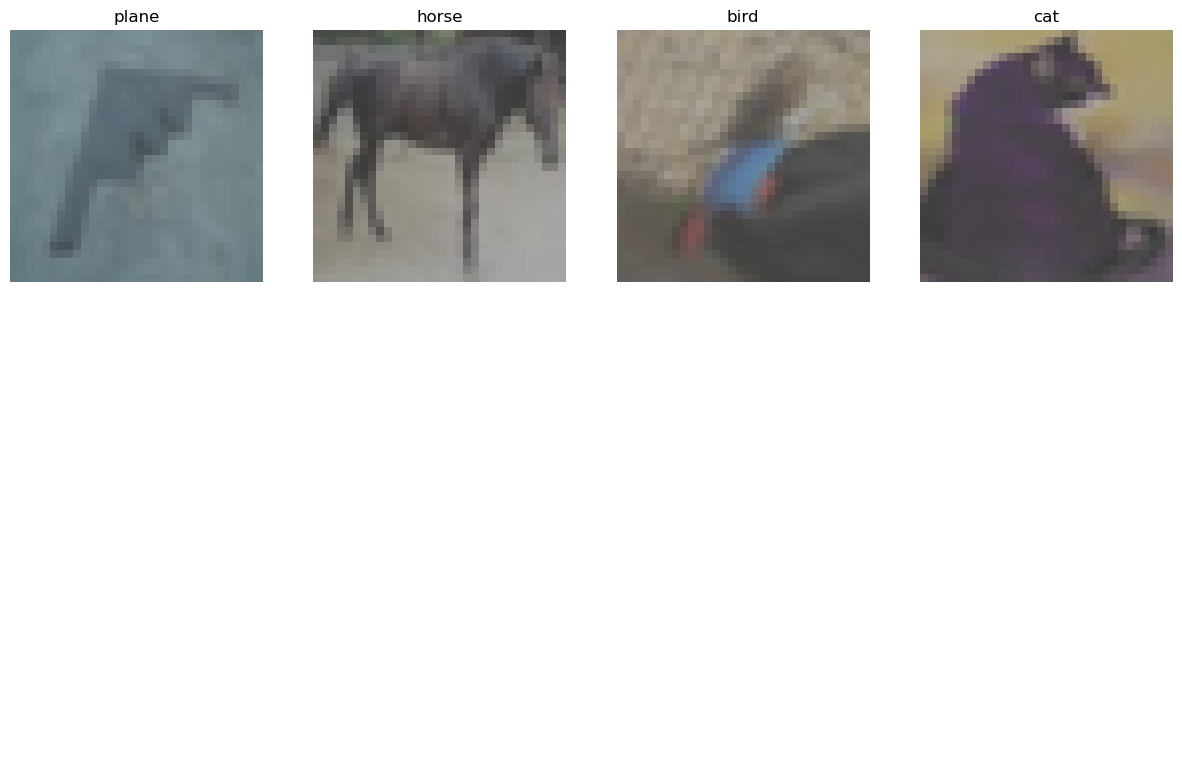

In [50]:
# get some random training images

dataiter = iter(testloader)
images, labels = next(dataiter)

# show images
imshow(images[:8], labels[:8])

# II. Construction du modèle

In [53]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc(x)
        return x

In [54]:
model = Net()
# model = model.cuda()

# III. Visualisation des filtres/paramètres du modèle à l’initialisation

# Méthode de visualisation des filtres

In [56]:
def visualize_filters(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = torchvision.utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.ioff()
    plt.show()

# Visualisation des filtres

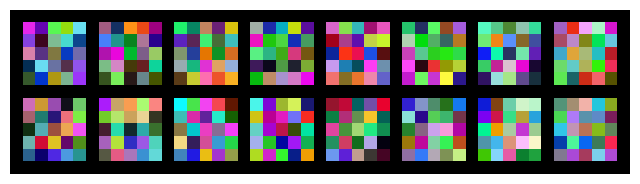

In [57]:
filters = model.conv1.weight.data.clone().cpu()
visualize_filters(filters, ch=0, allkernels=False)

# IV. L’apprentissage

## Fonction objectif, scheduler et optimizer

In [60]:
#Choose the loss function
criterion = nn.CrossEntropyLoss()

#Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
scheduler = MultiStepLR(optimizer, milestones=[25, 50], gamma=0.1)

## Méthodes d’évaluation 

In [62]:
import cv2

# Let us code a generic prediction function
def predict(model, loader, criterion=nn.CrossEntropyLoss(), feature_extract=False, max_size=0, resize=128):
    with torch.no_grad():
        if not feature_extract:
            model.eval()

        y_preds = []
        y_labels = []
        inputs_ = []

        running_loss = 0.0
        size = 0.0
        for idx, data in enumerate(loader):
            inputs, labels = data
            # inputs = inputs.cuda()
            # labels = labels.cuda()

            # wrap them in Variable
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            y_preds.extend(outputs.data.tolist())
            y_labels.extend(labels.data.tolist())
            if size <= max_size and feature_extract:
                images = [
                    cv2.resize(
                        (
                            (i*0.224+0.456)*255).astype('uint8').transpose((1, 2, 0)), dsize=(resize, resize)
                    ) for i in inputs.data.cpu().numpy()
                ]
                inputs_.extend(images)
                size = len(inputs_)

        predictions, labels, inputs = np.asarray(y_preds), np.asarray(y_labels), np.asarray(inputs_)

    if not feature_extract:
        return predictions, labels, running_loss/len(loader)

    return predictions, labels, inputs


def accuracy_topk(predictions, labels, top_k=1):
        res = 0
        for i, pred in enumerate(predictions):
            answer = np.argsort(-pred)[0:top_k]
            if labels[i] in answer:
                res += 1
        acc = float(res) / float(labels.shape[0])
        return acc

    
def evaluate(loader, model, top_k = 1, criterion = nn.CrossEntropyLoss()):
    predictions, labels, loss = predict(model, loader, criterion)
    return accuracy_topk(predictions, labels, top_k = top_k), loss

## Méthode d’apprentissage (i.e. d’optimisation)

In [63]:
####### Complete this part ######## or die ####################
def train(model, criterion, optimizer, scheduler):
    loss_history = []
    valid_loss_history = []

    acc_history = []
    val_acc_history = []

    print('**** Finished Training ****')
    return loss_history, valid_loss_history, acc_history, val_acc_history
###############################################################

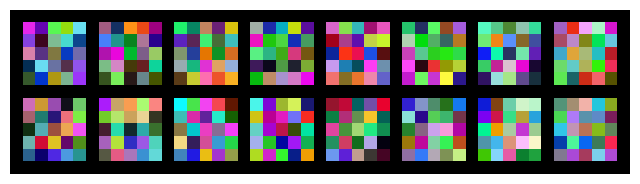

In [64]:
filters = model.conv1.weight.data.clone().cpu()
visualize_filters(filters, ch=0, allkernels=False)

In [65]:
accuracy, _ = evaluate(testloader, model)
print('Test accuracy: %.3f' % (accuracy), end='\n')

Test accuracy: 0.100


In [67]:
#Test prediction on some images
dataiter = iter(testloader)
images, labels = next(dataiter)
outputs = model(images[:8])#  .to(device))  # we use the loaded model
_, predicted = torch.max(outputs, 1)

imshow(images[:8], labels[:8], predicted[:8])

IndexError: index 4 is out of bounds for dimension 0 with size 4